In [1]:
%matplotlib inline

import copy
from datetime import date
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import sys
import time
import torch as pt

sys.path.insert(0, '../..')

from function_space import DenseNet_tanh, DenseNet
from problems import AllenCahn
from utilities import plot_loss_logs_extended, compute_test_error, do_importance_sampling, do_importance_sampling_Wei, plot_control_for_DoubleWell1d, plot_loss_logs, plot_solution, save_exp_logs, load_exp_logs
from solver import GeneralSolver

%load_ext autoreload
%autoreload 2

device = pt.device('cuda')

## Diffusion loss

In [2]:
d = 100
L = 60000
print_every = 1000
N = 25
delta_t = 0.001

seed = 42

problem = AllenCahn(d=d, T=0.3)
problem.modus = 'pt'
problem.boundary_distance = 7.0

models_diffusion = [GeneralSolver(problem, 'Diffusion', seed=42, delta_t=delta_t, N=N, lr=0.001, L=L, K=200,
                 K_boundary=50, alpha=[10.0, 1.0, 1.0], adaptive_forward_process=False, detach_forward=True,
                 print_every=print_every, verbose=True, approx_method='Y', sample_center=False, loss_method='diffusion', 
                loss_with_stopped=False, K_test_log=None, uniform_square=True),
         GeneralSolver(problem, 'Diffusion', seed=42, delta_t=delta_t, N=N, lr=0.001, L=L, K=200,
                 K_boundary=50, alpha=[1.0, 1.0, 1.0], adaptive_forward_process=False, detach_forward=True,
                 print_every=print_every, verbose=True, approx_method='Y', sample_center=False, loss_method='diffusion', 
                loss_with_stopped=False, K_test_log=None, uniform_square=True),
         GeneralSolver(problem, 'Diffusion', seed=42, delta_t=delta_t, N=N, lr=0.001, L=L, K=200,
                 K_boundary=50, alpha=[.1, 1.0, 1.0], adaptive_forward_process=False, detach_forward=True,
                 print_every=print_every, verbose=True, approx_method='Y', sample_center=False, loss_method='diffusion', 
                loss_with_stopped=False, K_test_log=None, uniform_square=True)]

for model in models_diffusion:
    model.V = DenseNet(d_in=d + 1, d_out=1, lr=0.001, arch=[110, 110, 50], seed=seed).to(device)

In [10]:
for model in models_diffusion:
    model.train()

0 - loss = 1.5148e-04, v L2 error = 0.0000e+00, n = 24, active: 183/200, 0.31
1000 - loss = 1.6011e-04, v L2 error = 0.0000e+00, n = 24, active: 189/200, 0.32
2000 - loss = 1.2819e-04, v L2 error = 0.0000e+00, n = 24, active: 183/200, 0.32
3000 - loss = 1.6286e-04, v L2 error = 0.0000e+00, n = 24, active: 183/200, 0.34
4000 - loss = 1.5038e-04, v L2 error = 0.0000e+00, n = 24, active: 179/200, 0.36
5000 - loss = 1.1956e-04, v L2 error = 0.0000e+00, n = 24, active: 191/200, 0.36
6000 - loss = 1.6040e-04, v L2 error = 0.0000e+00, n = 24, active: 184/200, 0.36
7000 - loss = 1.2582e-04, v L2 error = 0.0000e+00, n = 24, active: 184/200, 0.35
8000 - loss = 2.7512e-04, v L2 error = 0.0000e+00, n = 24, active: 181/200, 0.34
9000 - loss = 1.5702e-04, v L2 error = 0.0000e+00, n = 24, active: 186/200, 0.34
10000 - loss = 1.9910e-04, v L2 error = 0.0000e+00, n = 24, active: 191/200, 0.34
11000 - loss = 1.4077e-04, v L2 error = 0.0000e+00, n = 24, active: 187/200, 0.34
12000 - loss = 1.9778e-04, v 

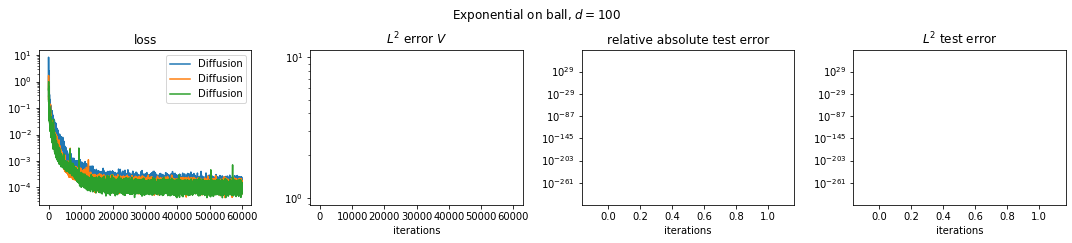

In [15]:
fig = plot_loss_logs_extended('Exponential on ball', models_diffusion)

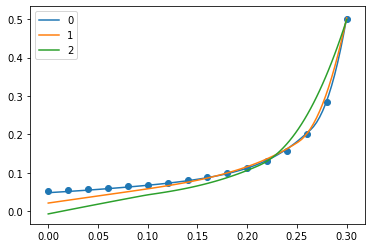

In [16]:
X_t = pt.cat([pt.tensor(problem.X_0).unsqueeze(0).float().repeat(100, 1), pt.linspace(0, 0.3, 100).unsqueeze(1)], 1).to(device)

for i, model in enumerate(models_diffusion):

    Y = model.V(X_t)[:, 0].detach().cpu().numpy()

    plt.plot(np.linspace(0, 0.3, 100), Y, label=i);
plt.scatter(np.linspace(0, 0.3, 16), [0.052802, 0.055111, 0.057786, 0.060893, 0.06455, 0.06887, 0.07406, 0.080428, 
                                      0.088329, 0.098481, 0.11179, 0.13036, 0.15746, 0.20131, 0.28407, 0.5])
plt.legend();

## PINN

In [4]:
d = 100
L = 60000
print_every = 1000
N = 25
delta_t = 0.001

seed = 42

problem = AllenCahn(d=d, T=0.3)
problem.modus = 'pt'
problem.boundary_distance = 7.0
problem.B = problem.B_pt

models_pinn_deep = [GeneralSolver(problem, 'PINN', seed=42, delta_t=delta_t, N=N, lr=0.001, L=L, K=200,
                 K_boundary=50, alpha=[10.0, 1.0, 1.0], adaptive_forward_process=False, detach_forward=True,
                 print_every=print_every, verbose=True, approx_method='Y', sample_center=False, loss_method='PINN', 
                loss_with_stopped=False, K_test_log=None, uniform_square=True),
         GeneralSolver(problem, 'PINN', seed=42, delta_t=delta_t, N=N, lr=0.001, L=L, K=200,
                 K_boundary=50, alpha=[1.0, 1.0, 1.0], adaptive_forward_process=False, detach_forward=True,
                 print_every=print_every, verbose=True, approx_method='Y', sample_center=False, loss_method='PINN', 
                loss_with_stopped=False, K_test_log=None, uniform_square=True),
         GeneralSolver(problem, 'PINN', seed=42, delta_t=delta_t, N=N, lr=0.001, L=L, K=200,
                 K_boundary=50, alpha=[.1, 1.0, 1.0], adaptive_forward_process=False, detach_forward=True,
                 print_every=print_every, verbose=True, approx_method='Y', sample_center=False, loss_method='PINN', 
                loss_with_stopped=False, K_test_log=None, uniform_square=True)]

for model in models_pinn_deep:
    model.V = DenseNet(d_in=d + 1, d_out=1, lr=0.001, arch=[110, 110, 50], seed=seed).to(device)

In [11]:
for model in models_pinn_deep:
    model.train()

0 - loss = 3.4093e-03 - v L2 error = 0.0000e+00 - 0.54
1000 - loss = 1.6636e-03 - v L2 error = 0.0000e+00 - 0.60
2000 - loss = 2.9568e-03 - v L2 error = 0.0000e+00 - 0.60
3000 - loss = 8.9302e-04 - v L2 error = 0.0000e+00 - 0.60
4000 - loss = 2.2257e-03 - v L2 error = 0.0000e+00 - 0.60
5000 - loss = 3.6338e-03 - v L2 error = 0.0000e+00 - 0.60
6000 - loss = 1.9521e-03 - v L2 error = 0.0000e+00 - 0.60
7000 - loss = 1.6416e-03 - v L2 error = 0.0000e+00 - 0.61
8000 - loss = 3.8202e-03 - v L2 error = 0.0000e+00 - 0.60
9000 - loss = 2.0723e-03 - v L2 error = 0.0000e+00 - 0.60
10000 - loss = 9.7416e-04 - v L2 error = 0.0000e+00 - 0.61
11000 - loss = 2.9774e-03 - v L2 error = 0.0000e+00 - 0.61
12000 - loss = 1.9494e-03 - v L2 error = 0.0000e+00 - 0.60
13000 - loss = 5.0966e-03 - v L2 error = 0.0000e+00 - 0.60
14000 - loss = 2.5310e-03 - v L2 error = 0.0000e+00 - 0.60
15000 - loss = 1.4874e-03 - v L2 error = 0.0000e+00 - 0.60
16000 - loss = 1.3597e-03 - v L2 error = 0.0000e+00 - 0.60
17000 - lo

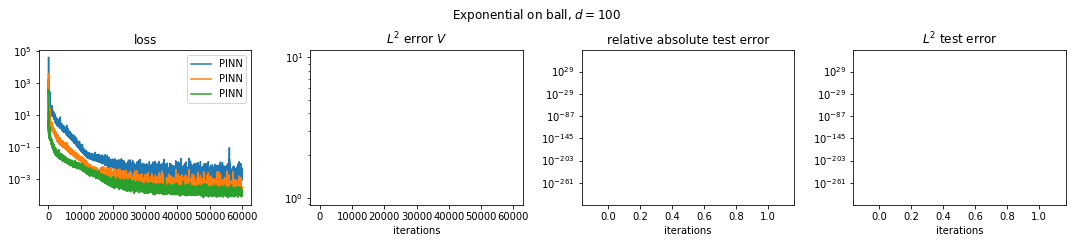

In [17]:
fig = plot_loss_logs_extended('Exponential on ball', models_pinn_deep)

In [6]:
d = 100
L = 80000
print_every = 1000
N = 300
delta_t = 0.001

seed = 42

problem = AllenCahn(d=d, T=0.3)
problem.modus = 'pt'
problem.boundary_distance = 7.0

#V = DenseNet(d, 1, lr=0.001).to(device)
#lambda_ = SingleParam(initial= 0.8 * problem.lambda_, lr=0.01).to(device)

models_bsde = [GeneralSolver(problem, 'BSDE', seed=42, delta_t=delta_t, N=N, lr=0.001, L=L, K=200,
                 K_boundary=50, alpha=[1.0, 1.0, 1.0], adaptive_forward_process=False, detach_forward=True,
                 print_every=print_every, verbose=True, approx_method='Y', sample_center=False, loss_method='BSDE', 
                loss_with_stopped=False, K_test_log=None, uniform_square=True)]

for model in models_bsde:
    model.V = DenseNet(d_in=d + 1, d_out=1, lr=0.001, arch=[110, 110, 50], seed=seed).to(device)

In [ ]:
for model in models_bsde:
    model.train()

0 - loss = 1.3002e-02, v L2 error = 0.0000e+00, n = 299, active: 0/200, 4.44
1000 - loss = 1.6720e-01, v L2 error = 0.0000e+00, n = 299, active: 1/200, 5.48
Not all trajectories stopped.
2000 - loss = 4.6178e-02, v L2 error = 0.0000e+00, n = 299, active: 1/200, 5.69
3000 - loss = 1.4330e-02, v L2 error = 0.0000e+00, n = 299, active: 0/200, 6.23
4000 - loss = 9.9817e-03, v L2 error = 0.0000e+00, n = 299, active: 1/200, 6.75
5000 - loss = 7.2956e-03, v L2 error = 0.0000e+00, n = 297, active: 0/200, 6.47
6000 - loss = 3.9877e-03, v L2 error = 0.0000e+00, n = 299, active: 2/200, 6.36
7000 - loss = 3.1271e-03, v L2 error = 0.0000e+00, n = 299, active: 4/200, 6.65
Not all trajectories stopped.
Not all trajectories stopped.
8000 - loss = 2.0534e-03, v L2 error = 0.0000e+00, n = 299, active: 1/200, 4.90
9000 - loss = 1.3904e-03, v L2 error = 0.0000e+00, n = 299, active: 0/200, 4.72
10000 - loss = 1.2587e-03, v L2 error = 0.0000e+00, n = 298, active: 0/200, 4.75
11000 - loss = 5.7321e-04, v L2 

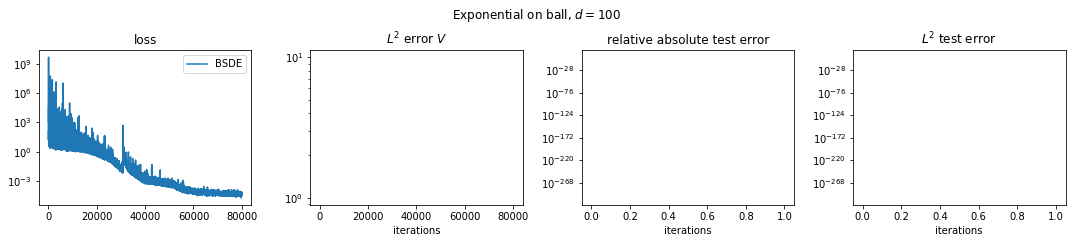

In [19]:
fig = plot_loss_logs_extended('Exponential on ball', models_bsde)

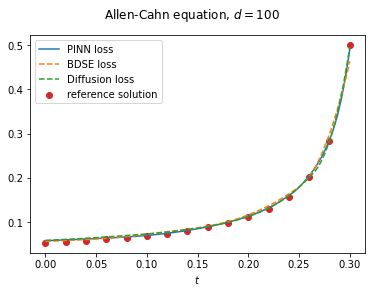

In [73]:
COLORS = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown',
          'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

X_t = pt.cat([pt.tensor(problem.X_0).unsqueeze(0).float().repeat(100, 1), pt.linspace(0, 0.3, 100).unsqueeze(1)], 1).to(device)

model_pinn = models_pinn_deep[2]
model_bsde = models_bsde[0]
model_diffusion = models_diffusion[0]

fig.suptitle(r'Allen-Cahn equation, $d = 100$')

ax.plot(np.linspace(0, 0.3, 100), model_pinn.V(X_t)[:, 0].detach().cpu().numpy(), label='PINN loss');
ax.plot(np.linspace(0, 0.3, 100), model_bsde.V(X_t)[:, 0].detach().cpu().numpy(), '--', label='BDSE loss');
ax.plot(np.linspace(0, 0.3, 100), model_diffusion.V(X_t)[:, 0].detach().cpu().numpy(), '--', label='Diffusion loss');
ax.scatter(np.linspace(0, 0.3, 16), [0.052802, 0.055111, 0.057786, 0.060893, 0.06455, 0.06887, 0.07406, 0.080428, 
                                      0.088329, 0.098481, 0.11179, 0.13036, 0.15746, 0.20131, 0.28407, 0.5],
           label='reference solution', color='tab:red')
ax.legend();
ax.set_xlabel(r'$t$')

#fig.savefig('img/allen-cahn-comparison.pdf')


In [70]:
sum(model_pinn.times) / 60

325.45814393758775

In [71]:
sum(model_diffusion.times) / 60

194.3797233223915

In [72]:
sum(model_bsde.times) / 60

4280.676939022541